# Respiratory Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the respiratory rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.
    
    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate the respiratory rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    
4. Metrics:

    4.1. Respiratory Rate Per Minute (RPM): extrapolate RPM, and make an histogram of the result. Does it follow a particular distribution?

    4.2. Respiratory Rate Variability (RRV): extrapolate RRV, explain why this parameter is important, and plot the results.


5. **Optional**: Elaborate a simple algorithm to extrapolate the respiratory rate even when the filter fails (e.g. look for a particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as spy
import seaborn as sns
import sklearn
from statistics import mean

from scipy.interpolate import interp1d
from scipy.interpolate import barycentric_interpolate
from scipy import fft, signal, interpolate, fftpack
from sklearn import preprocessing

# 1 Analysis of center_sternum.txt

## 1.1 Data preparation

### 1.1.1 Load the raw data and select columns

For the analysis we decided to consider the data obtained from accelerometer, gyroscope and magnetometer.

In [2]:
df = pd.read_csv('center_sternum.txt', delimiter = "\t")
df = df[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']]
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...
16501,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


### 1.1.2 Plot selected data and choose a proper time window 

We plotted the selected data as a function of time. As we can see on the images first and last 10 seconds are very nosy, so we removed those data from the dataset.

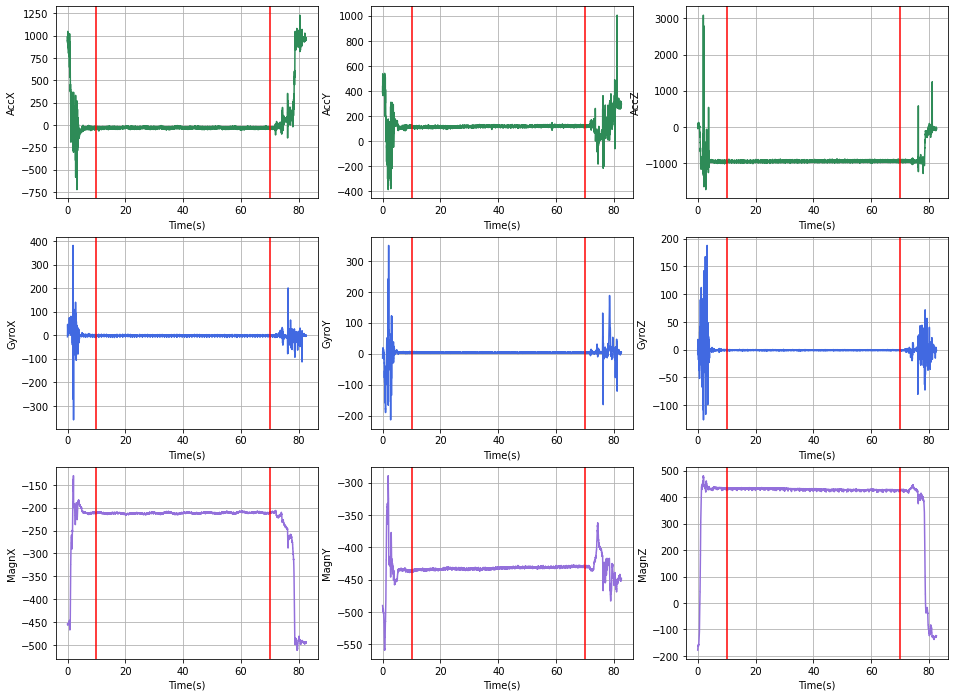

In [3]:
fs = 200
x = np.linspace(0, df.shape[0] / fs, df.shape[0])

y_label = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
color = ['seagreen', 'seagreen', 'seagreen', 'royalblue', 'royalblue', 'royalblue', 'mediumpurple', 'mediumpurple', 'mediumpurple']

fig, axs = plt.subplots(3, 3, figsize = (16, 12))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df[y_label[i]], color = color[i])
    ax.axvline(x = 10, color = 'r')
    ax.axvline(x = 70, color = 'r')
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    ax.grid()
    

#### Meaningful data

In [4]:
df2 = df.iloc[2000:14000, :].copy()
x = np.linspace(0, df2.shape[0]/fs, df2.shape[0])

df2
x.size

12000

### 1.1.3 Calibration

We used infornation about offset data and calibration matrix from configuration file to make calibration.

In [5]:
gyro_offset = np.array([-2.242224,2.963463,-0.718397])

acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])

magn_cal = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset = np.array([-95.67974,-244.9142,17.71132])

df2[['GyroX','GyroY','GyroZ']] = df2[['GyroX','GyroY','GyroZ']] + gyro_offset
df2[['AccX','AccY','AccZ']] = np.dot(df2[['AccX','AccY','AccZ']], acc_cal.T) + acc_offset
df2[['MagnX','MagnY','MagnZ']] = np.dot(df2[['MagnX','MagnY','MagnZ']], magn_cal.T) + magn_offset

df2

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,-36.191918,98.305357,-897.115495,-0.486499,7.986364,-1.527557,-278.856972,-639.776198,393.017911
2001,-22.684157,97.764133,-915.007862,-0.684972,7.161936,-1.802366,-278.856972,-639.776198,393.017911
2002,-31.003173,96.009994,-887.561201,-1.310926,7.284074,-1.817634,-278.021365,-637.071851,389.534964
2003,-25.334931,99.274992,-884.079327,-1.295659,7.100867,-1.985573,-278.021365,-637.071851,389.534964
2004,-35.980596,103.453468,-867.603353,-1.219323,7.665753,-1.710763,-278.876743,-638.857065,393.896969
...,...,...,...,...,...,...,...,...,...
13995,-40.052097,98.944783,-880.026254,-5.387262,6.429112,-1.329084,-278.141105,-632.501729,388.681452
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195


### 1.1.4 Plot meaningful data

After calibration we plotted the meaningful data as a function of time.

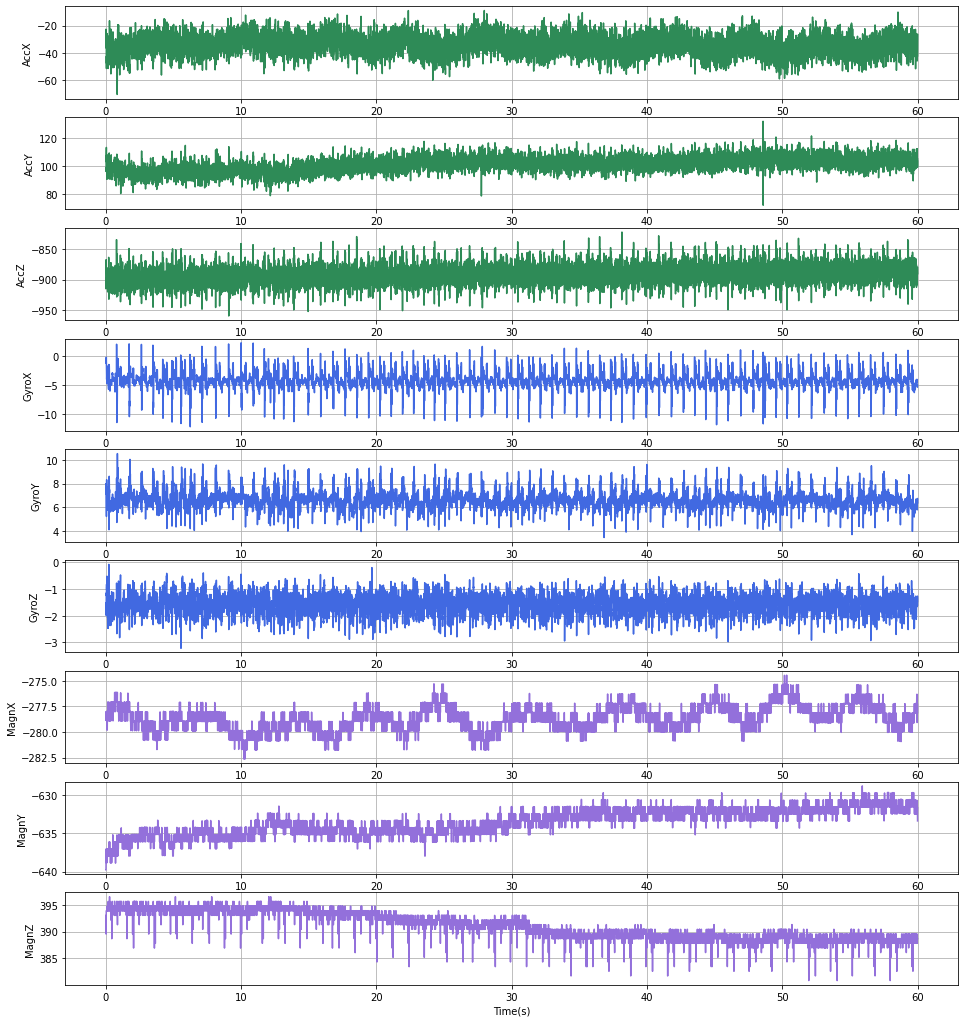

In [6]:
fig, axs = plt.subplots(9, 1, figsize = (16, 18))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df2[y_label[i]], color = color[i])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    ax.grid()

## 1.2 Time and frequency analysis
### 1.2.1 Statistical analysis
#### Mean, median, variance, standard deviation, 25th and 75th percentiles

From the statistical analysis we can found out all three accelerometer axes have significant variability which means they are very noisy and more sensitive to the subject's movements. In order to better understand the meaning of this data we need to filter the data and make further analysis.

In [7]:
stat = pd.DataFrame({'Mean': df2.mean(), 'Median': df2.median(), 'Variance': df2.var(), 'Standard deviation': df2.std(),
    '25% percentile': df2.quantile(q = 0.25), '75% percentile': df2.quantile(q = 0.75)})
stat

,Mean,Median,Variance,Standard deviation,25% percentile,75% percentile
AccX,-34.234293,-34.158425,49.260255,7.018565,-38.854045,-29.560357
AccY,100.900265,101.068429,27.191455,5.214543,97.480937,104.345627
AccZ,-892.401054,-892.838259,208.983725,14.456269,-900.970347,-884.565100
GyroX,-4.326728,-4.394896,1.996583,1.413005,-4.929247,-3.723140
GyroY,6.646299,6.597051,0.507940,0.712699,6.245906,6.963463
GyroZ,-1.587087,-1.573359,0.131751,0.362975,-1.817634,-1.344351
MagnX,-278.667645,-278.966269,1.470737,1.212739,-279.106893,-278.050465
MagnY,-633.583895,-633.408090,2.762531,1.662086,-635.170051,-632.474220
MagnZ,391.063967,390.435310,6.520047,2.553438,388.688414,393.902779


#### Correlation coefficients

In [8]:
df2_corr = df2.corr()
df2_corr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.180828,-0.412005,0.203288,0.010442,0.025054,-0.386831,-0.051802,0.087693
AccY,-0.180828,1.000000,0.165032,-0.050947,-0.011371,-0.133083,0.243585,0.358844,-0.490141
AccZ,-0.412005,0.165032,1.000000,-0.079125,0.112730,0.025872,0.123488,0.190235,-0.236575
GyroX,0.203288,-0.050947,-0.079125,1.000000,0.395832,0.383160,-0.058950,-0.065203,0.026454
GyroY,0.010442,-0.011371,0.112730,0.395832,1.000000,0.436120,0.010498,-0.139320,0.027379
GyroZ,0.025054,-0.133083,0.025872,0.383160,0.436120,1.000000,-0.017122,-0.059217,0.008068
MagnX,-0.386831,0.243585,0.123488,-0.058950,0.010498,-0.017122,1.000000,0.255512,-0.326848
MagnY,-0.051802,0.358844,0.190235,-0.065203,-0.139320,-0.059217,0.255512,1.000000,-0.739075
MagnZ,0.087693,-0.490141,-0.236575,0.026454,0.027379,0.008068,-0.326848,-0.739075,1.000000


For better performance we normalized the data.

In [9]:
df_Norm = pd.DataFrame(preprocessing.normalize(df2, axis=0), columns=df2.columns)
df_Norm

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,-0.009454,0.008882,-0.009176,-0.000976,0.010907,-0.008565,-0.009135,-0.009218,0.009174
1,-0.005926,0.008833,-0.009359,-0.001374,0.009781,-0.010106,-0.009135,-0.009218,0.009174
2,-0.008099,0.008675,-0.009078,-0.002629,0.009948,-0.010192,-0.009107,-0.009179,0.009093
3,-0.006618,0.008970,-0.009042,-0.002599,0.009697,-0.011133,-0.009107,-0.009179,0.009093
4,-0.009399,0.009347,-0.008874,-0.002445,0.010469,-0.009592,-0.009135,-0.009205,0.009195
...,...,...,...,...,...,...,...,...,...
11995,-0.010462,0.008940,-0.009001,-0.010805,0.008780,-0.007452,-0.009111,-0.009113,0.009073
11996,-0.008997,0.009398,-0.009046,-0.010866,0.008634,-0.008394,-0.009082,-0.009100,0.009073
11997,-0.009507,0.009355,-0.009056,-0.010499,0.009072,-0.007110,-0.009082,-0.009100,0.009073
11998,-0.006856,0.008949,-0.009118,-0.010560,0.009218,-0.007195,-0.009111,-0.009126,0.009073


## 1.2.2 Frequency Analysis
### 1.2.2.1 FFT

In [ ]:
#df_fft = pd.DataFrame(columns=df_Norm.columns)
#df_fft_pwr = pd.DataFrame(columns=df_Norm.columns)
#for c in df_Norm.columns:
#    df_fft[c] = fft.fft(np.array(df_Norm[c]))
#    df_fft_pwr[c] = np.abs(df_fft[c])
#df_fft_pwr



df_fft = df_Norm.apply(np.fft.fft)
df_fft_pwr = df_fft.apply(np.abs)

df_fft_pwr

In [ ]:
freq = fft.fftfreq(df_fft.shape[0] , d=1/fs)
freq

Removing bias (power at zero frequency).

In [ ]:
df_fft_pwr.loc[0] = 0
df_fft_pwr

In [ ]:
fig, axs = plt.subplots(9,1, figsize = (16,18))
for i, ax in enumerate(axs.flat):   
    
    _d = np.array(df_fft_pwr.iloc[:,i])
    _peaks, _property = signal.find_peaks(_d, distance=fs)
    
        
    ax.set_ylim([0, _d[_peaks].max()*1.1])
    ax.plot(freq, _d, color=color[i])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(df_fft_pwr.columns[i])
    ax.grid()
    #ax.set_xlim([-5,5])
    #ax.axvline(x = 0.16, color = 'r')
    #ax.axvline(x = 1.16, color = 'r')
    

From frequency spectrum it is obvious that main information is in frequencies below 40 Hz. However, different approches could be used to find HR and RR. Cut-off frequencies of filter depends on the selected approach.

### 1.2.2.2 Finding HR and RR in frequency domain

Normal heart rate is between 40 bpm and 100 bpm, while maximum HR during exercises is up to 255-age bpm, though it depends on the age. Normal respiratory rate is between 10 and 20 breaths per minute for adults, while for childs it could be up to 60 breaths per minue. From these facts it is concluded that main frequencies should be less than 4.25 Hz for HR and less than 1 for RR, which are confirmed by low-frequency high-power harmonics in the spectrum. 

Considering that our goal is to estimate the respiratory rate of an healthy subject, and we do not need clear HR waveform or other specific properties of HR wavefor, we use a bandpass filter with cut-off frequencies equal to 0.04 Hz and 2 Hz.



In [ ]:
df_fft_pwr = df_fft_pwr.drop(df_fft_pwr[freq <= 0].index)
freq = freq[np.where(freq > 0)]

In [ ]:

f_low_cut = 0.04
f_high_cut = 4

peak_freq = []

fig, axs = plt.subplots(9,1, figsize = (16,18))

for i, ax in enumerate(axs.flat): 
    
    
    #### Filtering frequencies
    _d = np.array(df_fft_pwr.iloc[:,i])
    _mask = np.where(np.abs(freq) < f_low_cut)
    _d[_mask] = 0
    _mask = np.where(np.abs(freq) > f_high_cut)
    _d[_mask] = 0

    
    # Finding freq. with peak power
    peak_freq.append(freq[_d.argmax()])
        
    ax.plot(freq, _d , color=color[i])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(df_fft_pwr.columns[i])
    ax.grid()
    
    ax.set_xlim([0,4.5])
    ax.set_ylim([0, (_d[_d.argmax()])*1.1])
    ax.plot(freq[_d.argmax()], _d[_d.argmax()], 'X', color='r')


By selecting main peak in the [0.04,4] Hz interval and voting on all signals, HR and RR could be find.

In [ ]:
F = np.array(np.unique(peak_freq , return_counts=True))[0,-2:]
HR = F.max()
RR = F.min()
print(f'HR frequency is {HR:.2f} Hz, which is equal to {HR*60:.2f} beats per minute.')
print(f'RR frequency is {RR:.2f} Hz, which is equal to {RR*60:.2f} breath per minute.')


### 1.2.2.4 Filtered signal visualisation

From Fourier analysis it can be noticed that for the accelerometer the only axis that needs to be considered is the X axis, as there is a peak frequency of 0.17 Hz. Peak frequencies of other two axes are too low to be studied for a respiratory rate.

For the gyroscope all three big peaks are associated with the heart rate frequency. However, we can consider a small peak in the RR frequency interval.

The analysis of the magnetometer Fourier transform, shows us that there are peaks both around the frequency found for the respiration rate of 0.17 Hz and around the frequency estimated to be the heart rate of 1.15 Hz.

As we found RR frequency is 0.17 Hz we apply filter in interval [0.1, 0.3] Hz.

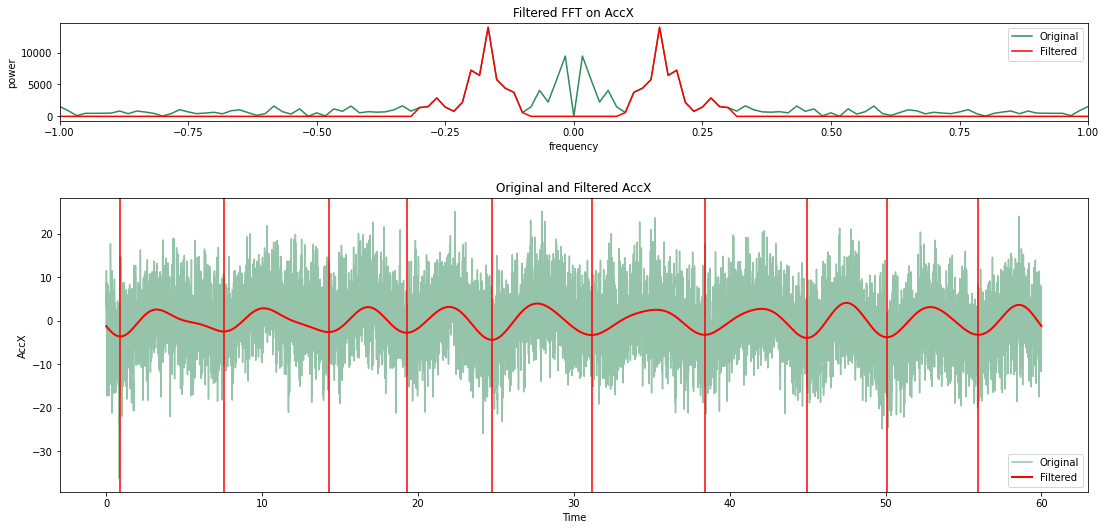

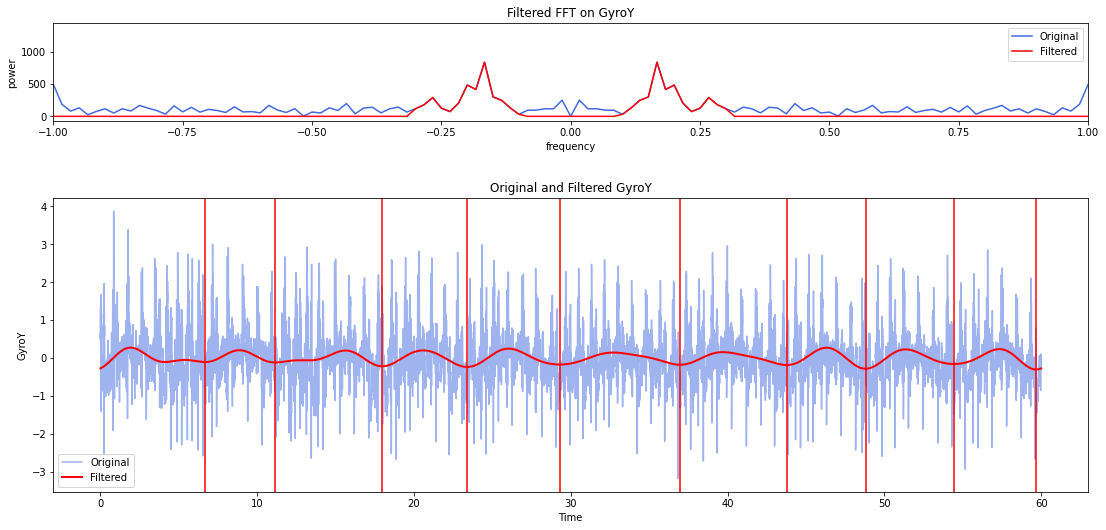

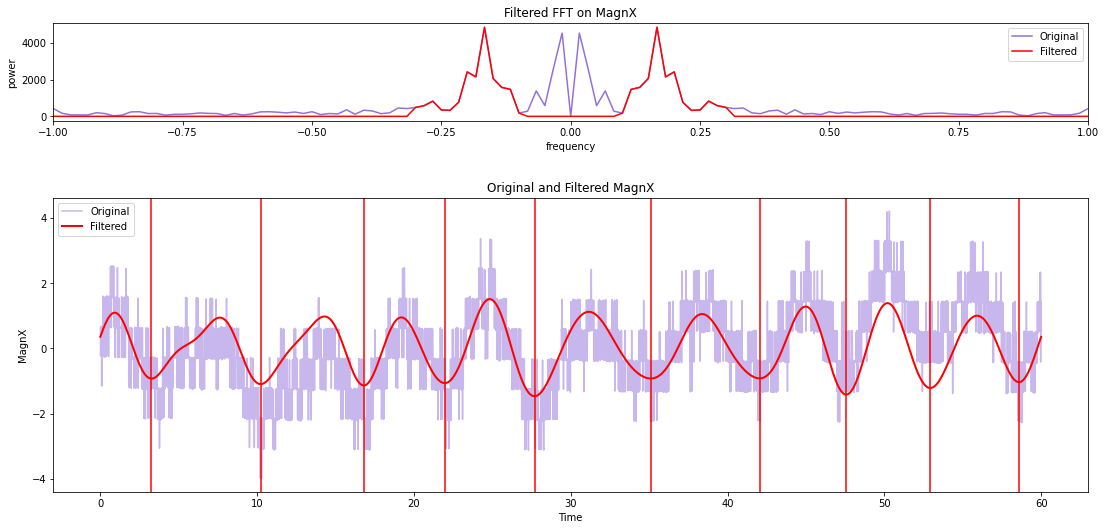

In [10]:
rr_int = [0.1, 0.3]

def fft_calc(sig_name):
    # The FFT of the signal
    sig = df2[sig_name].to_numpy()
    sig -= np.mean(sig)
    sig_fft = fftpack.fft(sig)

    # And the power (sig_fft is of complex dtype)
    power = np.abs(sig_fft) # these are the "weights" of the Fourier components for each discrete frequency interval

    # The return the corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size, d=1/fs)
    return sig_fft, power, sample_freq

fft_y_label = ['AccX', 'GyroY', 'MagnX']

for label in fft_y_label:
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 8), gridspec_kw={'height_ratios': [1, 3]})
   
    sig_fft, power, sample_freq = fft_calc(label)
    filter_fft = np.where((np.abs(sample_freq)<rr_int[0]) | (np.abs(sample_freq) >rr_int[1]))
    sig_fft[filter_fft] = 0

    df_fft = pd.DataFrame(list(zip(sample_freq, power, np.abs(sig_fft))), columns = ['sample_freq', 'power', 'filtered_fft'])
    df_fft = df_fft.sort_values(by=['sample_freq', 'power', 'filtered_fft'])

    ax1.plot(df_fft['sample_freq'],df_fft['power'],color=color[fft_y_label.index(label)*3],label='Original')
    ax1.plot(df_fft['sample_freq'],df_fft['filtered_fft'],color='r',label='Filtered')
    ax1.set_xlim(-1,1)
    ax1.set(xlabel="frequency", ylabel="power",title="Filtered FFT on " + label)

    ax1.legend()
    
    filtered_sig = fftpack.ifft(sig_fft)
    filtered_sig = np.real(filtered_sig)

    ax2.plot(x, df2[label], alpha=0.5, color=color[fft_y_label.index(label)*3], label='Original')
    ax2.plot(x, filtered_sig, linewidth=2, color='r', label='Filtered')

    ## Min of the filtered signal
    minima = signal.argrelextrema(filtered_sig, np.less, order = 500)
    for i in minima[0]:
        plt.axvline(x[i], color = 'r')

    ax2.set_xlabel('Time')
    ax2.set_ylabel(label)
    ax2.set_title('Original and Filtered ' + label)
    ax2.legend()
    plt.tight_layout(pad=3.0)
    plt.show()


### 1.2.2.3 Time domain analysis on filtered signal

Although the previous method can be used to obtain heart rate and respiration rate, this method does not seem very suitable for a more complete analysis. Therefore, after applying the appropriate filter on the data and removing unwanted noise and frequencies, we perform the analysis in the time domain.

To do this, we perform a bandpass filter on data with [0.04 , 40] Hz allow band.

In [ ]:

df_fft = df2.apply(np.fft.fft)
df_fft_pwr = df_fft.apply(np.abs)
freq = fft.fftfreq(df_fft.shape[0] , d=1/fs)

df_fft_pwr

##### 1.2.2.3.1 Filtering

In [ ]:
f_low_cut = 0.04
f_high_cut = 40

In [ ]:
df_fpf = df_fft_pwr.copy()      #df_fft_pwr_filtered ==> df_fpf


#sos = signal.butter(4, [f_low_cut, f_high_cut], fs=fs, btype="band", output="sos")
sos = signal.butter(10,  f_high_cut, fs=fs, btype="low", output="sos")

sos
#df_fpf.loc[np.abs(freq) > f_high_cut] *= 0.01
#df_fpf.loc[np.abs(freq) < f_low_cut] *= 0.01
#df_fpf

In [ ]:
filtered_df = df.apply(lambda x: signal.sosfilt(sos,x)).copy()



#filtered_df = df_fpf.apply(np.fft.ifft)
# only take the real part
real_filtered_df = filtered_df.apply(np.real)
real_filtered_df

##### 1.2.2.3.2 Statistics of filtered signal

In [ ]:
real_filtered_df.describe()

##### 1.2.2.3.3 Selecting meaningful data

In [ ]:
real_filtered_df2 = real_filtered_df.iloc[2000:14000, :].copy()
real_filtered_df2

##### 1.2.2.3.3 Normalizing filtered signal

In [ ]:
real_filtered_df2 = real_filtered_df.iloc[2000:14000, :].copy()
real_filtered_df2 = pd.DataFrame(preprocessing.normalize(real_filtered_df2, axis=0), columns=real_filtered_df.columns)
real_filtered_df2

##### 1.2.2.3.3 Statistics of normalized meaningful data

In [ ]:
real_filtered_df2.describe()

creating sample points based on sample frequency and portion of data.

In [ ]:
x = np.linspace(real_filtered_df2.index.start,real_filtered_df2.index.stop/fs, real_filtered_df2.shape[0])
x

### 1.2.2.3.4 Finding RR based on moving average

**Calculating moving average and finding its minimums and maximums**

In [ ]:
moving_avg =real_filtered_df2.apply(lambda x: x.rolling(window=fs).mean())

max_mva = moving_avg.apply(lambda x: signal.argrelextrema(np.array(x), np.greater, order=fs))
min_mva = moving_avg.apply(lambda x: signal.argrelextrema(np.array(x), np.less, order=fs))



We fit a sinusoidal function on extremum point (min or max) of moving average. The frequency of fitted function is the RR frequency. We do voting amonge all columns to decide final RR.

In [ ]:

RR_mvm = []

fig, axs = plt.subplots(9, 1, figsize = (16, 18))
for i, ax in enumerate(axs.flat):
 
    _c = y_label[i]
    _d = moving_avg[_c]    
    _p = [x for x in list(max_mva[_c][0])]
    
    def f(x, A, nu, B):
        return A * np.sin(nu * x) + B # sine function with amplitude A and angular frequency

    popt, pcov = spy.optimize.curve_fit(f, x[max_mva[_c][0]], _d[_p])
    
    RR_mvm.append(60*popt[1]/np.pi/2)
    print(f'{_c}: freq. = {popt[1]/np.pi/2:.2f} ==> RR = {60*popt[1]/np.pi/2:2.0f} bpm.')    
    
#    ax.plot(x , real_filtered_df2[y_label[i]])
    ax.plot(x , _d, color=color[i], label='moving average')  
    ax.plot(x[_p], _d[_p],'*',color='red', label='extremums')
    ax.plot(x, f(x, popt[0], popt[1], popt[2]), color='yellow', label='fitted function')

    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    ax.grid() 
    


print(25*'*')
print(f'Calculated RR by using moving average in time domain is {mean(RR_mvm):2.0f} bpm. ')

### 1.2.2.3.5 Finding RR based on peaks of signal

In [ ]:
#peak_freq = real_filtered_df2.apply(lambda x: signal.find_peaks(-x, distance=fs/2))

max_sig = real_filtered_df2.apply(lambda x: signal.argrelextrema(np.array(x), np.greater, order=fs))
min_sig = real_filtered_df2.apply(lambda x: signal.argrelextrema(np.array(x), np.less, order=fs))


In [ ]:
RR_peaksig = []

fig, axs = plt.subplots(9, 1, figsize = (16, 18))
for i, ax in enumerate(axs.flat):
 
    _c = y_label[i]
    _d = real_filtered_df2[_c]    
    _p = [x for x in list(max_sig[_c][0])]
    
    def f(x, A, nu, B):
        return A * np.sin(nu * x) + B # sine function with amplitude A and angular frequency

    popt, pcov = spy.optimize.curve_fit(f, x[max_sig[_c][0]], _d[_p], full_output=False)
    
    RR_peaksig.append(60*popt[1]/np.pi/2)
    print(f'{_c}: freq. = {popt[1]/np.pi/2:.2f} ==> RR = {60*popt[1]/np.pi/2:2.0f} bpm.')    
    
#    ax.plot(x , real_filtered_df2[y_label[i]])
    ax.plot(x , _d, color=color[i], label='moving average')  
    ax.plot(x[_p], _d[_p],'*',color='red', label='extremums')
    ax.plot(x, f(x, popt[0], popt[1], popt[2]), color='yellow', label='fitted function')

    ax.set_xlabel('Time(s)')
    ax.set_ylabel(_c)
    ax.grid() 
    


print(25*'*')
print(f'Calculated RR by using moving average in time domain is {mean(RR_peaksig):2.0f} bpm. ')

## 1.2.4 Metrics

In previous sections we used all portion of meaningful data (60 seconds). Now we will do exact analysis using a sliding window of data.
To achive this, we use a 10 seconds windows and moving it on the data by 1 second steps.

In [ ]:


def fft_analysis2(_df):
    
    df_fft = _df.apply(np.fft.fft)
    df_fft_pwr = df_fft.apply(np.abs)


    freq = fft.fftfreq(df_fft.shape[0] , d=1/fs)


    df_fft_pwr.loc[0] = 0
#    df_fft_pwr
    
#    fig, axs = plt.subplots(9,1, figsize = (16,18))
#    for i, ax in enumerate(axs.flat):   
    
#        _d = np.array(df_fft_pwr.iloc[:,i])
#        _peaks, _property = signal.find_peaks(_d, distance=fs)
    
        
#        ax.set_ylim([0, _d[_peaks].max()*1.1])
#        ax.plot(freq, _d, color=color[i])
#        ax.set_xlabel('Frequency (Hz)')
#        ax.set_ylabel(df_fft_pwr.columns[i])
#        ax.grid()
        #ax.set_xlim([-5,5])
        #ax.axvline(x = 0.16, color = 'r')
        #ax.axvline(x = 1.16, color = 'r')
        
#    print(df_fft_pwr[freq <= 0].index)
#    df_fft_pwr = df_fft_pwr.drop(df_fft_pwr[freq <= 0].index)
#    freq = freq[np.where(freq > 0)]


    f_low_cut = 0.04
    f_high_cut = 4

    peak_freq = []

#    fig, axs = plt.subplots(9,1, figsize = (16,18))

#    for i, ax in enumerate(axs.flat): 
    
    for i,c in enumerate(df_fft_pwr.columns):     
        #### Filtering frequencies
        _d = np.array(df_fft_pwr.iloc[:,i])
        _mask = np.where(np.abs(freq) < f_low_cut)
        _d[_mask] = 0
        _mask = np.where(np.abs(freq) > f_high_cut)
        _d[_mask] = 0

    
        # Finding freq. with peak power
        peak_freq.append(freq[_d.argmax()])
        
#        ax.plot(freq, _d , color=color[i])
#        ax.set_xlabel('Frequency (Hz)')
#        ax.set_ylabel(df_fft_pwr.columns[i])
#        ax.grid()
    
#        ax.set_xlim([0,4.5])
#        ax.set_ylim([0, (_d[_d.argmax()])*1.1])
#        ax.plot(freq[_d.argmax()], _d[_d.argmax()], 'X', color='r')


    F = np.array(np.unique(peak_freq , return_counts=True))[0,-2:]
    HR = F.max()
    RR = F.min()

#    print(f'HR frequency is {HR:.2f} Hz, which is equal to {HR*60:.2f} beats per minute.')
#    print(f'RR frequency is {RR:.2f} Hz, which is equal to {RR*60:.2f} breath per minute.')
    
    return RR*60







In [ ]:
swnd= 10 #size of sliding window
swnd_step = 1 # size of steps for moving swnd

swnd_sample = swnd*fs
swnd_step_sample = swnd_step*fs



RPM = []
for i in range(50):
    a = 2000+i*swnd_step_sample
    b = 2000+i*swnd_step_sample+swnd_sample
    RPM.append(fft_analysis2(df_Norm[a:b]))
    
    print(f'{i}: a={a}\tb={b}\tb-a={b-a}\tRR={RPM[i]}')

#print(RPM)


plt.plot(RPM)
print(mean(RPM))

In [ ]:

def fn_mva(_df):
    



    df_fft = _df.apply(np.fft.fft)
    df_fft_pwr = df_fft.apply(np.abs)
    freq = fft.fftfreq(df_fft.shape[0] , d=1/fs)

    df_fft_pwr

    f_low_cut = 0.04
    f_high_cut = 40


    df_fpf = df_fft_pwr.copy()      #df_fft_pwr_filtered ==> df_fpf


#sos = signal.butter(4, [f_low_cut, f_high_cut], fs=fs, btype="band", output="sos")
    sos = signal.butter(10,  f_high_cut, fs=fs, btype="low", output="sos")

    sos
#df_fpf.loc[np.abs(freq) > f_high_cut] *= 0.01
#df_fpf.loc[np.abs(freq) < f_low_cut] *= 0.01
#df_fpf

    filtered_df = _df.apply(lambda x: signal.sosfilt(sos,x)).copy()



#filtered_df = df_fpf.apply(np.fft.ifft)
# only take the real part
    real_filtered_df = filtered_df.apply(np.real)
    real_filtered_df2 = real_filtered_df.copy()

#    real_filtered_df2 = real_filtered_df.iloc[2000:14000, :].copy()
    real_filtered_df2

#    real_filtered_df2 = real_filtered_df.iloc[2000:14000, :].copy()
#    real_filtered_df2 = pd.DataFrame(preprocessing.normalize(real_filtered_df2, axis=0), columns=real_filtered_df.columns)
    real_filtered_df2

    x = np.linspace(real_filtered_df2.index.start,real_filtered_df2.index.stop/fs, real_filtered_df2.shape[0])
    x


    moving_avg =real_filtered_df2.apply(lambda x: x.rolling(window=fs).mean())

    max_mva = moving_avg.apply(lambda x: signal.argrelextrema(np.array(x), np.greater, order=fs))
    min_mva = moving_avg.apply(lambda x: signal.argrelextrema(np.array(x), np.less, order=fs))



    RR_mvm = []

#    fig, axs = plt.subplots(9, 1, figsize = (16, 18))
#    for i, ax in enumerate(axs.flat):
    for i, c in enumerate(moving_avg.columns): 
        _c = y_label[i]
        _d = moving_avg[_c]    
        _p = [x+real_filtered_df2.index.start for x in list(max_mva[_c][0])]
    
        def f(x, A, nu, B):
            return A * np.sin(nu * x) + B # sine function with amplitude A and angular frequency
        
#        print(x[max_mva[_c][0]])
        popt, pcov = spy.optimize.curve_fit(f, x[max_mva[_c][0]], _d[_p], full_output=False)
    
        RR_mvm.append(60*popt[1]/np.pi/2)
#        print(f'{_c}: freq. = {popt[1]/np.pi/2:.2f} ==> RR = {60*popt[1]/np.pi/2:2.0f} bpm.')    
    
#    ax.plot(x , real_filtered_df2[y_label[i]])
#        ax.plot(x , _d, color=color[i], label='moving average')  
#        ax.plot(x[_p], _d[_p],'*',color='red', label='extremums')
#        ax.plot(x, f(x, popt[0], popt[1], popt[2]), color='yellow', label='fitted function')

#        ax.set_xlabel('Time(s)')
#        ax.set_ylabel(y_label[i])
#        ax.grid() 
    


#    print(25*'*')
#    print(f'Calculated RR by using moving average in time domain is {mean(RR_mvm):2.0f} bpm. ')
    return mean(RR_mvm)
    
    
    


In [ ]:


swnd= 20 #size of sliding window
swnd_step = 1 # size of steps for moving swnd

swnd_sample = swnd*fs
swnd_step_sample = swnd_step*fs



RPM = []
for i in range(40):
    a = 0+i*swnd_step_sample
    b = 0+i*swnd_step_sample+swnd_sample
    try:
        RPM.append(fn_mva(df[a:b]))
        print(f'{i}: a={a}\tb={b}\tb-a={b-a}\tRR={RPM[i]}')
    except:
        print(f'{i} ==> error!')

#print(RPM)


plt.hist(RPM, bins=20)
print(mean(RPM))

# 2 Analysis of 4_Chest_sweater.txt
## 2.1 Data preparation
### 2.1.1 Load the raw data and select columns

Chest_sweater dataset were chosen from the datasets given, because this sensor has the same position as the sensor in the first dataset.

In [11]:
df_m = pd.read_csv('4_Chest_sweater.txt', delimiter = "\t")
df_m = df_m[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']]
df_m

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113
1,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128
2,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136
3,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145
4,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157
...,...,...,...,...,...,...,...,...,...
14933,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50
14934,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51
14935,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54
14936,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53


### 2.1.2 Plot selected data and choose a proper time window 

For this dataset we remove first and last 5 seconds of the noisy data.

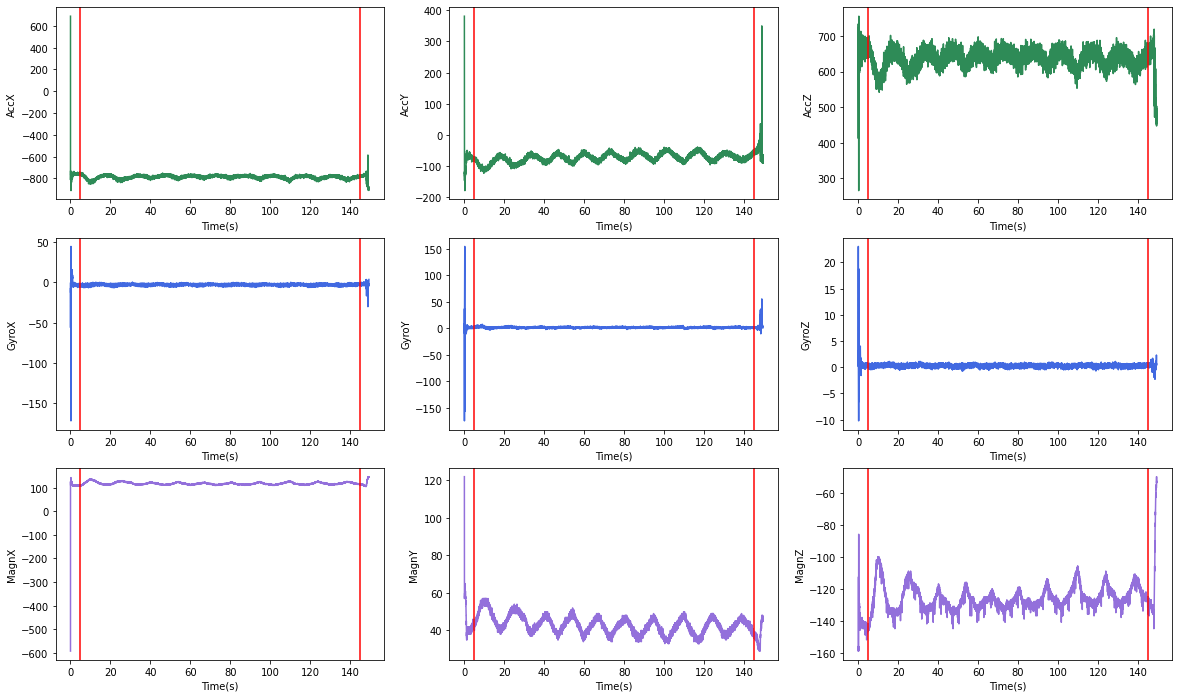

In [12]:
fs_m = 100
x = np.linspace(0, df_m.shape[0] / fs_m, df_m.shape[0])

y_label = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
color = ['seagreen', 'seagreen', 'seagreen', 'royalblue', 'royalblue', 'royalblue', 'mediumpurple', 'mediumpurple', 'mediumpurple']

fig, axs = plt.subplots(3, 3, figsize = (20, 12))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df_m[y_label[i]], color = color[i])
    ax.axvline(x = 5, color = 'r')
    ax.axvline(x = 145, color = 'r')
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    

#### Meaningful data

In [13]:
df2_m = df_m.iloc[5000:14500, :].copy()
x = np.linspace(0, 100, 9500)
df2_m

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
5000,-787.327,-77.775,644.831,-3.048780,2.073171,0.609756,114,43,-132
5001,-768.600,-72.224,632.265,-3.048780,2.073171,0.243902,115,43,-134
5002,-769.027,-75.701,631.960,-3.536585,1.951220,0.121951,112,44,-132
5003,-767.014,-72.712,671.793,-3.658537,2.195122,0.121951,114,43,-131
5004,-774.456,-79.727,648.796,-4.024390,2.317073,0.121951,112,43,-133
...,...,...,...,...,...,...,...,...,...
14495,-785.497,-58.560,650.870,-2.560976,0.731707,0.000000,112,36,-127
14496,-786.046,-51.301,651.236,-2.804878,1.097561,0.487805,113,38,-125
14497,-786.107,-54.534,641.110,-2.560976,1.463415,0.365854,114,39,-129
14498,-769.149,-53.436,657.092,-2.560976,0.731707,0.365854,114,37,-128


### 2.1.3 Calibration

We used infornation about offset data and calibration matrix from configuration file to make calibration.

In [14]:
gyro_offset = np.array([-2.804399,1.793105,0.3411708])

acc_cal = np.array([[1.002982,9.415505E-05,0.00434674],
                    [9.04459E-05,1.002731,-0.001444198],
                    [0.004346536,-0.001444751,1.030587]])
acc_offset = np.array([3.602701,-20.96658,54.97186])

magn_cal = np.array([[1.013437,-0.04728858,-0.001861475],
                   [-0.04728862,1.004832,0.008222118],
                   [-0.001861605,0.008221965,0.9439077]])
magn_offset = np.array([-150.4098,74.62431,630.9805])

df2_m[['GyroX','GyroY','GyroZ']] = df2_m[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df2_m[['AccX','AccY','AccZ']] = np.dot(df2_m[['AccX','AccY','AccZ']],acc_cal.T) + acc_offset.T
df2_m[['MagnX','MagnY','MagnZ']] = np.dot(df2_m[['MagnX','MagnY','MagnZ']],magn_cal.T) + magn_offset.T

### 2.1.4 Plot meaningful data

After calibration we plotted the meaningful data as a function of time.

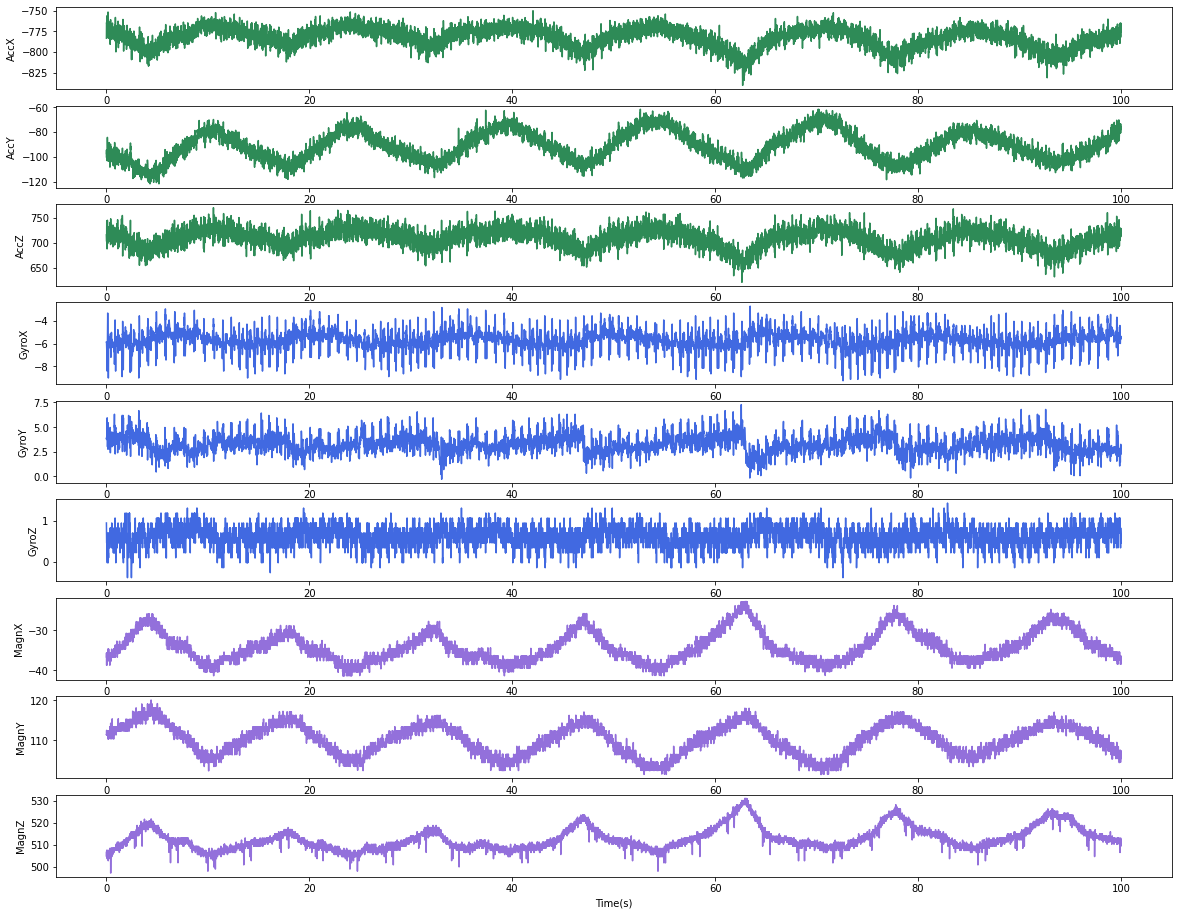

In [15]:
fig, axs = plt.subplots(9, 1, figsize = (20, 16))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df2_m[y_label[i]], color = color[i])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])

## 2.2 Time and frequency analysis
### 2.2.1 Statistical analysis
#### Mean, median, variance, standard deviation, 25th and 75th percentiles

In [16]:
stat = pd.DataFrame({'Mean': df2_m.mean(), 'Median': df2_m.median(), 'Variance': df2_m.var(), 'Standard deviation': df2_m.std(),
    '25% percentile': df2_m.quantile(q = 0.25), '75% percentile': df2_m.quantile(q = 0.75)})
stat

,Mean,Median,Variance,Standard deviation,25% percentile,75% percentile
AccX,-782.497313,-780.581870,153.772009,12.400484,-790.592225,-773.251856
AccY,-91.348752,-91.756841,136.156687,11.668620,-100.844818,-81.711607
AccZ,709.256381,711.217123,379.656967,19.484788,697.027239,722.911802
GyroX,-5.633398,-5.609277,0.624834,0.790464,-6.097082,-5.121472
GyroY,3.311218,3.256520,0.826324,0.909024,2.768715,3.866276
GyroZ,0.615266,0.585073,0.056250,0.237171,0.463122,0.828976
MagnX,-34.079233,-34.651833,13.967551,3.737319,-36.623972,-31.664395
MagnY,110.075221,110.314009,13.761966,3.709712,107.330358,113.188684
MagnZ,512.808933,512.146480,25.949210,5.094037,509.313981,515.044754


#### Correlation coefficients

In [17]:
df2_m_corr = df2_m.corr()
df2_m_corr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,0.708211,0.642489,0.002826,0.010146,0.039991,-0.816159,-0.700990,-0.815615
AccY,0.708211,1.000000,0.669704,0.035174,-0.017886,0.019043,-0.834970,-0.916337,-0.692920
AccZ,0.642489,0.669704,1.000000,0.017334,-0.042930,-0.008367,-0.732824,-0.641051,-0.722038
GyroX,0.002826,0.035174,0.017334,1.000000,-0.536020,0.495455,-0.018548,-0.002448,-0.024733
GyroY,0.010146,-0.017886,-0.042930,-0.536020,1.000000,-0.553634,-0.005313,-0.002807,-0.013630
GyroZ,0.039991,0.019043,-0.008367,0.495455,-0.553634,1.000000,-0.027724,-0.020949,-0.026502
MagnX,-0.816159,-0.834970,-0.732824,-0.018548,-0.005313,-0.027724,1.000000,0.853223,0.903564
MagnY,-0.700990,-0.916337,-0.641051,-0.002448,-0.002807,-0.020949,0.853223,1.000000,0.721079
MagnZ,-0.815615,-0.692920,-0.722038,-0.024733,-0.013630,-0.026502,0.903564,0.721079,1.000000


### 2.2.2 FFT
RR interval at normal breathing frequencies between approximately 0.1 and 0.5 Hz 

Peak frequency of AccX : 0.07368421052631578
Peak frequency of AccY : 0.07368421052631578
Peak frequency of AccZ : 0.07368421052631578
Peak frequency of GyroX : 0.07368421052631578
Peak frequency of GyroY : 0.07368421052631578
Peak frequency of GyroZ : 0.07368421052631578
Peak frequency of MagnX : 0.07368421052631578
Peak frequency of MagnY : 0.07368421052631578
Peak frequency of MagnZ : 0.07368421052631578


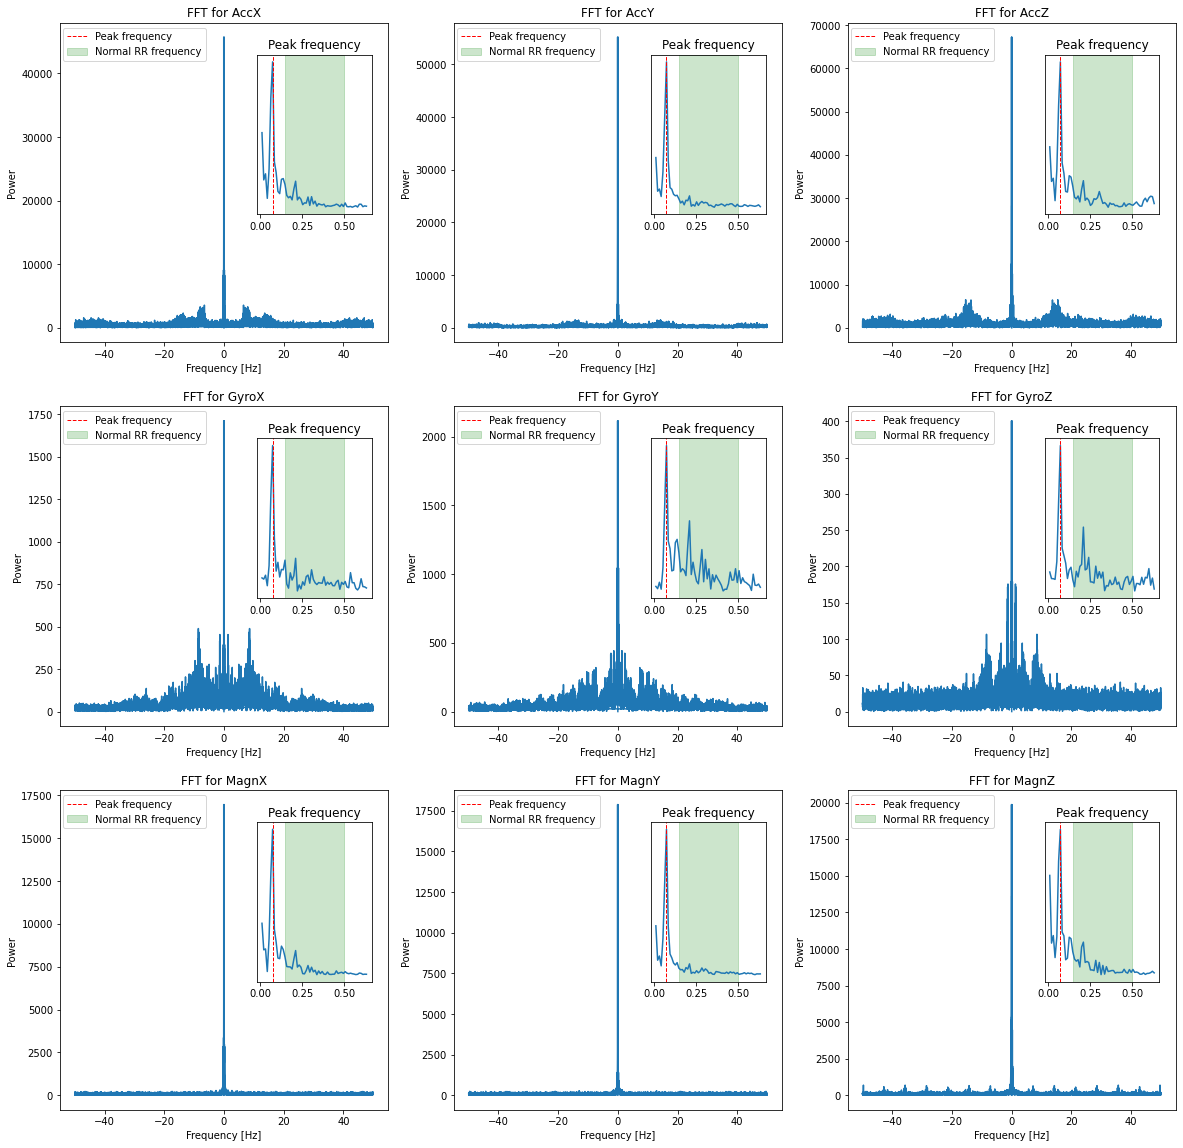

In [18]:
rr_int = [0.1, 0.5]

def fft_culc(sig_name):
    # The FFT of the signal
    sig = df2_m[sig_name].to_numpy()
    sig -= np.mean(sig)
    sig_fft = fftpack.fft(sig)

    # And the power (sig_fft is of complex dtype)
    power = np.abs(sig_fft) # these are the "weights" of the Fourier components for each discrete frequency interval

    # The return the corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size, d=1/fs_m)
    return sig_fft, power, sample_freq

fig, axs = plt.subplots(3, 3, figsize = (20, 20))
for i, ax in enumerate(axs.flat):
    sig_name = y_label[i]
    
    
    sig_fft, power, sample_freq = fft_culc(sig_name)
    
    # Plot the FFT power
    ax.set_title('FFT for ' + sig_name)
    ax.plot(sample_freq, power)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power')

    # Find the peak frequency: focus only on only the positive frequencies
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    powes = power[pos_mask]
    # find the max of freqs array
    peak_freq = freqs[powes.argmax()]
    print("Peak frequency of",sig_name,":", peak_freq)

    # An inner plot to show the peak frequency
    ins = ax.inset_axes([0.6, 0.4, 0.35, 0.5])
    ins.set_title('Peak frequency')
    if (peak_freq < 1):
        interval = 60
    else:
        interval = 100
    ins.plot(freqs[:interval], powes[:interval])
    ins.axvline(x=peak_freq, color='r', linestyle='--', lw = 1, label='Peak frequency')
    ins.set_yticks([])
    ins.axvspan(0.15, 0.5, alpha=0.2, color='green', label='Normal RR frequency')
    ins.legend(bbox_to_anchor=(-0.4, 1.2))
    

### 2.2.2.4 Filtered signal visualisation

From Fourier analysis it can be noticed that all axes have a peak of 0.074 Hz which is smaller than 0.1 Hz. So we can consider it as RR.

Due to the sensor position the data is more noisy than the first dataset. We decided to filter the data in normal RR interval [0.1, 0.5] Hz for all axes.

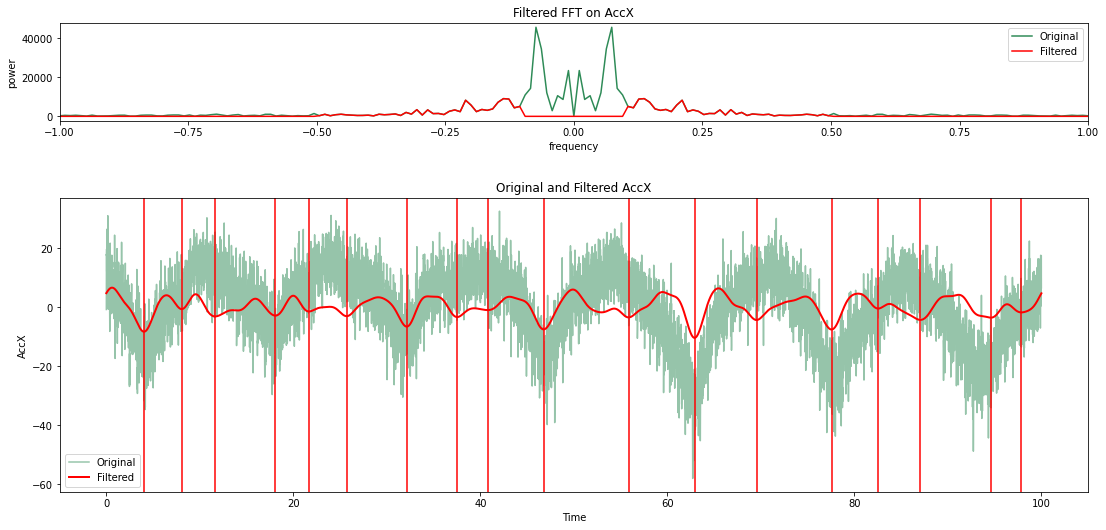

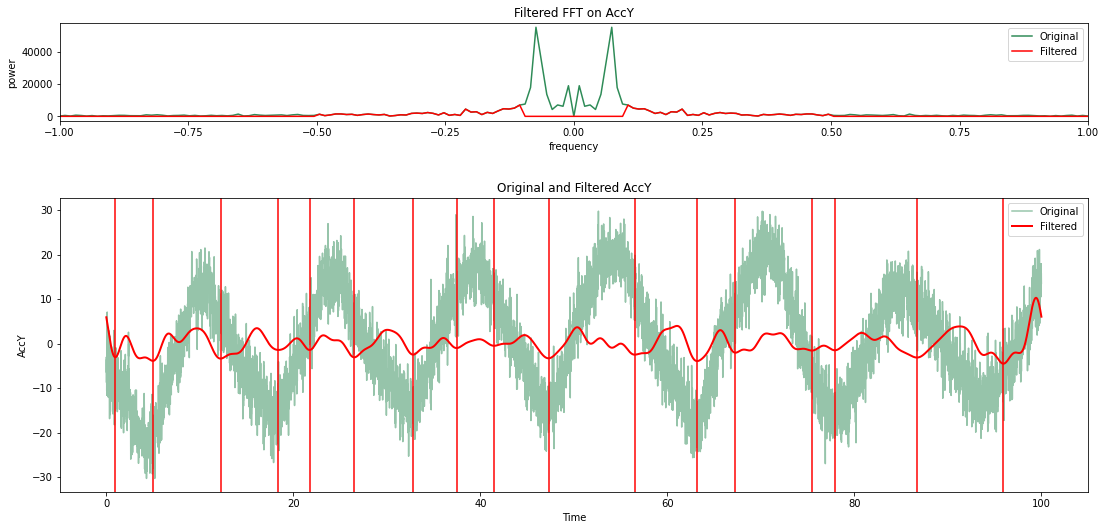

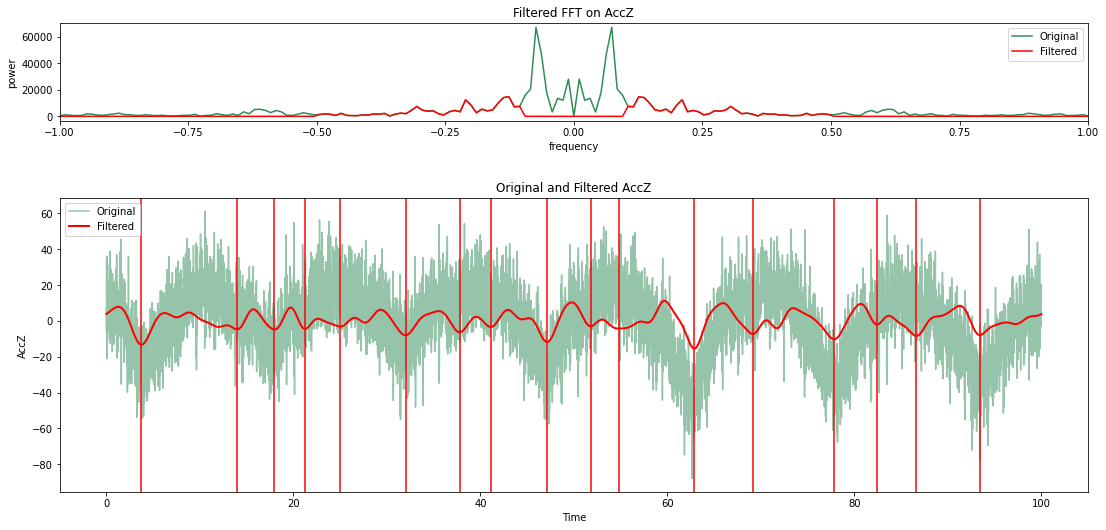

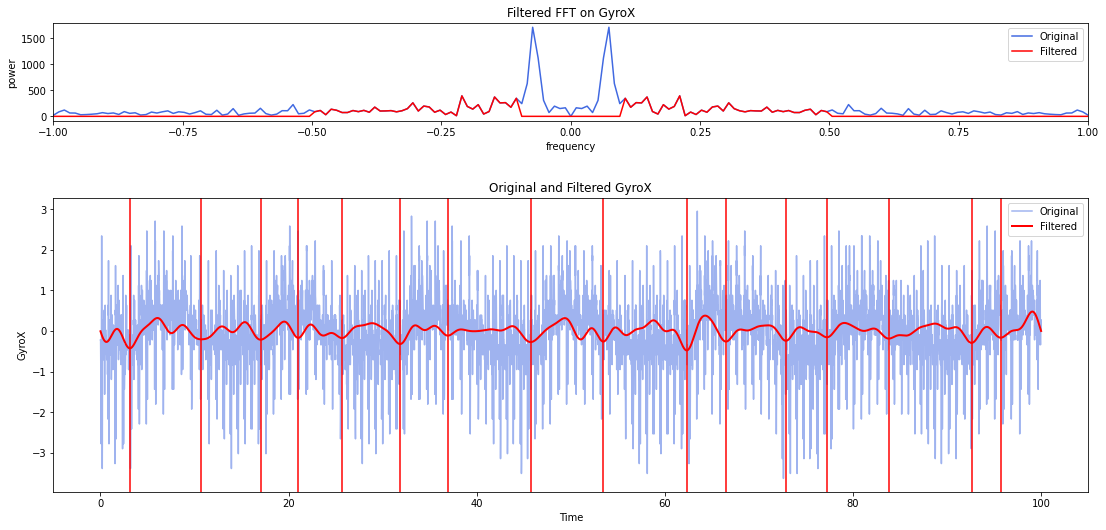

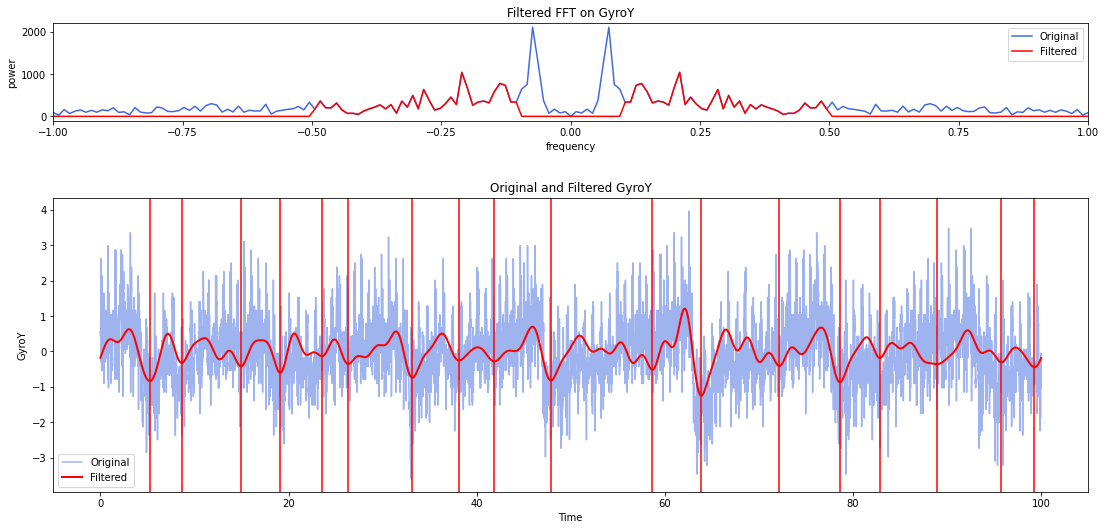

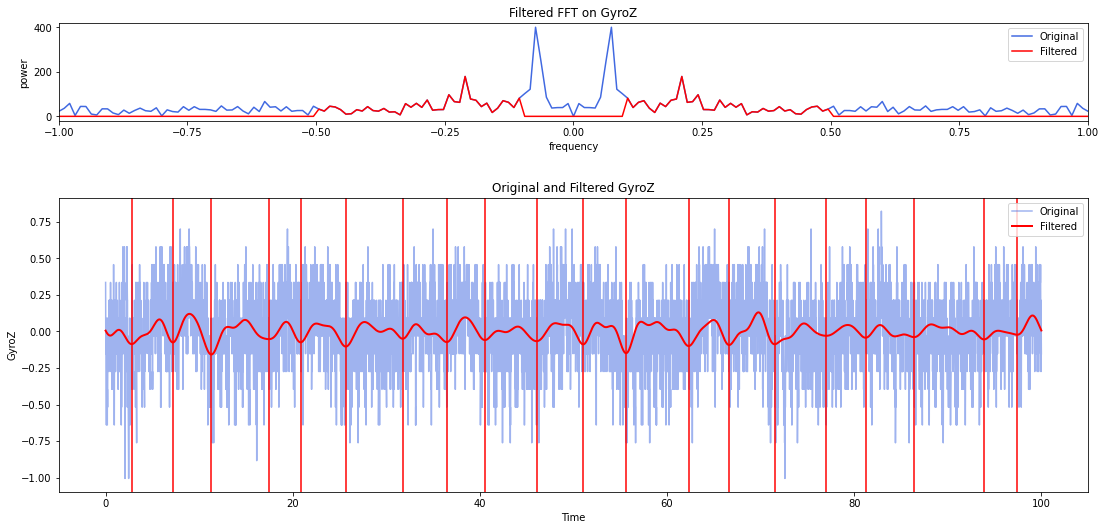

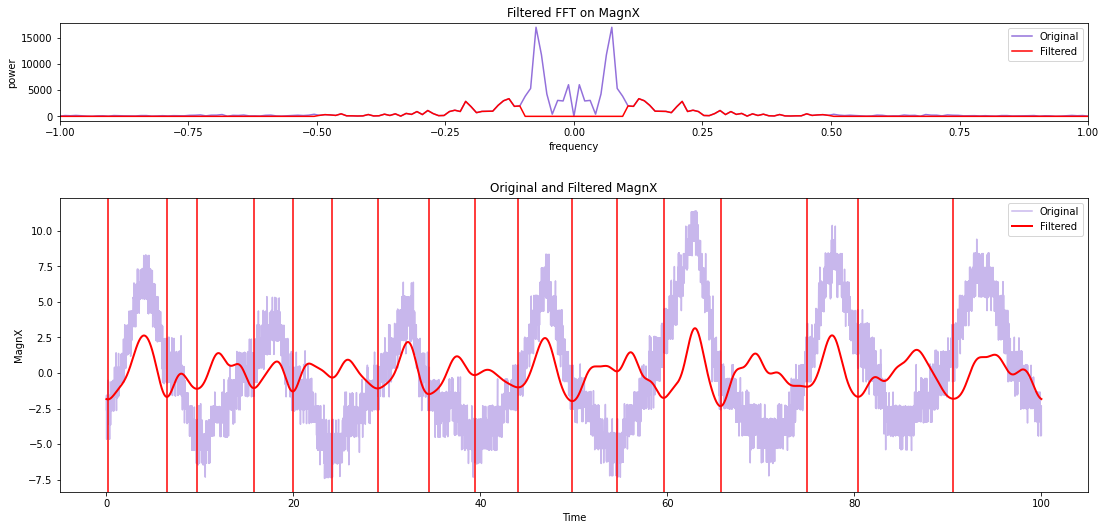

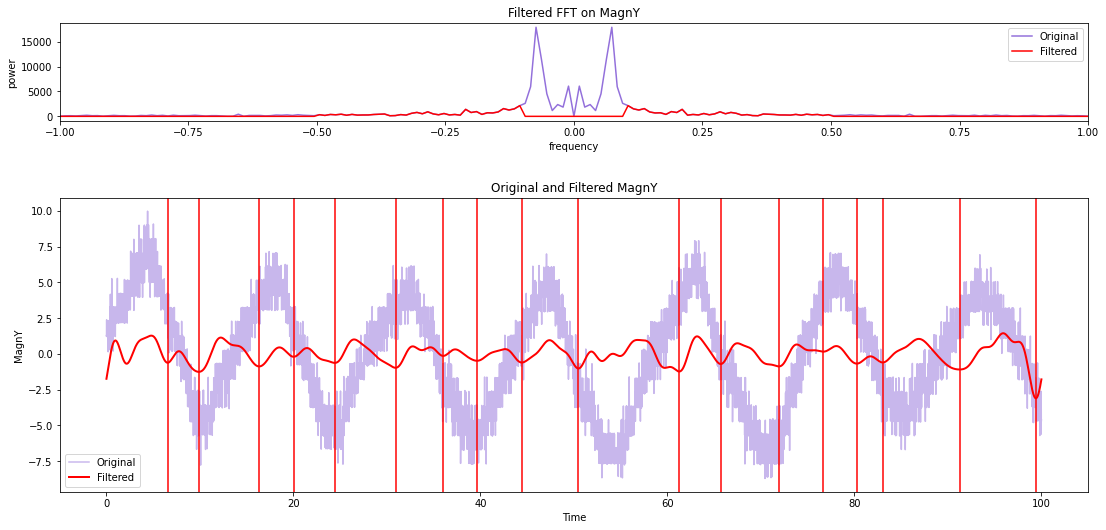

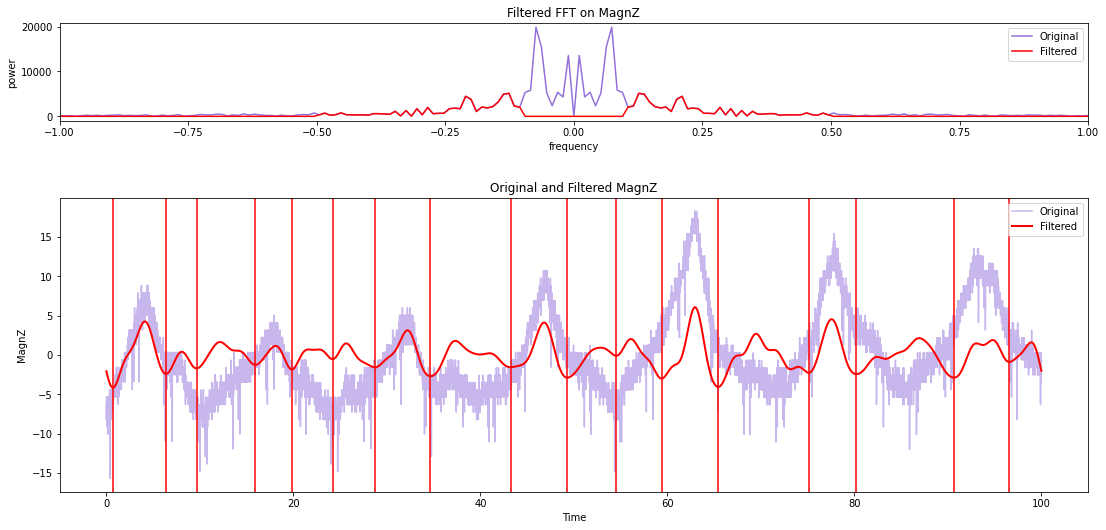

In [19]:
rr_int = [0.1, 0.5]

def fft_calc(sig_name):
    # The FFT of the signal
    sig = df2_m[sig_name].to_numpy()
    sig -= np.mean(sig)
    sig_fft = fftpack.fft(sig)

    # And the power (sig_fft is of complex dtype)
    power = np.abs(sig_fft) # these are the "weights" of the Fourier components for each discrete frequency interval

    # The return the corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size, d=1/fs_m)
    return sig_fft, power, sample_freq

fft_y_label = ['AccX', 'AccY', 'AccZ']

for label in y_label:
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 8), gridspec_kw={'height_ratios': [1, 3]})
   
    sig_fft, power, sample_freq = fft_calc(label)
    filter_fft = np.where((np.abs(sample_freq)<rr_int[0]) | (np.abs(sample_freq) >rr_int[1]))
    sig_fft[filter_fft] = 0

    df_fft = pd.DataFrame(list(zip(sample_freq, power, np.abs(sig_fft))), columns = ['sample_freq', 'power', 'filtered_fft'])
    df_fft = df_fft.sort_values(by=['sample_freq', 'power', 'filtered_fft'])

    ax1.plot(df_fft['sample_freq'],df_fft['power'],color=color[y_label.index(label)],label='Original')
    ax1.plot(df_fft['sample_freq'],df_fft['filtered_fft'],color='r',label='Filtered')
    ax1.set_xlim(-1,1)
    ax1.set(xlabel="frequency", ylabel="power",title="Filtered FFT on " + label)

    ax1.legend()
    
    filtered_sig = fftpack.ifft(sig_fft)
    filtered_sig = np.real(filtered_sig)

    ax2.plot(x, df2_m[label], alpha=0.5, color=color[y_label.index(label)], label='Original')
    ax2.plot(x, filtered_sig, linewidth=2, color='r', label='Filtered')

    ## Min of the filtered signal
    minima = signal.argrelextrema(filtered_sig, np.less, order = 200)
    for i in minima[0]:
        plt.axvline(x[i], color = 'r')

    ax2.set_xlabel('Time')
    ax2.set_ylabel(label)
    ax2.set_title('Original and Filtered ' + label)
    ax2.legend()
    plt.tight_layout(pad=3.0)
    plt.show()
